# Carga de Librerias

In [8]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

from datetime import datetime
from pathlib import Path
from curl_cffi import requests

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.ensemble import VotingRegressor
from scipy.stats import zscore
import pickle
from pandas_datareader import data as pdr
from numpy.linalg import inv

# Descarga de Datos

Obtención de los tickers a partir de la web de Wikipedia

In [4]:
import pandas as pd

# URL de Wikipedia con los componentes del IBEX 35
url = "https://es.wikipedia.org/wiki/IBEX_35"

# Leer todas las tablas de la página
tablas = pd.read_html(url)

# Seleccionar la tabla correcta (Componentes)
tabla_ibex = tablas[1]

# Extraer los tickers y formatearlos para Yahoo Finance (añadiendo ".MC")
tickers = tabla_ibex["Ticker"].tolist()
tickers = [ticker + ".MC" for ticker in tickers]

# Mostrar resultado
print("Tickers del IBEX 35 obtenidos automáticamente:")
print(tickers)


Tickers del IBEX 35 obtenidos automáticamente:
['ANA.MC', 'ANE.MC', 'ACX.MC', 'ACS.MC', 'AENA.MC', 'AMS.MC', 'MTS.MC', 'SAB.MC', 'BKT.MC', 'BBVA.MC', 'CABK.MC', 'CLNX.MC', 'ENG.MC', 'ELE.MC', 'FER.MC', 'FDR.MC', 'GRF.MC', 'IAG.MC', 'IBE.MC', 'ITX.MC', 'IDR.MC', 'COL.MC', 'LOG.MC', 'MAP.MC', 'MEL.MC', 'MRL.MC', 'NTGY.MC', 'RED.MC', 'REP.MC', 'ROVI.MC', 'SCYR.MC', 'SAN.MC', 'SLR.MC', 'TEF.MC', 'UNI.MC']


In [3]:
session = requests.Session(impersonate="chrome124")

# Descargar datos diarios ajustados hasta el 2025-05-30
data_full = yf.download(
    tickers=tickers,
    start="1990-01-01",  # Muy anterior para asegurarte de obtener el máximo disponible
    end="2025-05-30",
    interval="1d",
    group_by="ticker",
    auto_adjust=True,       # Precios ajustados por dividendos y splits
    actions=True,           # Incluye dividendos y splits como columnas
    threads=True,
    progress=True
)

# Guardar el DataFrame completo en CSV
data_full.to_csv("IBEX35_DATA", index=True)

# Mostrar ejemplo de datos descargados para un ticker
print(data_full[tickers[0]].head())

[*********************100%***********************]  35 of 35 completed


Price           Open      High       Low     Close  Volume  Dividends  \
Date                                                                    
2000-01-03  0.066457  0.068191  0.065143  0.068131  184093        0.0   
2000-01-04  0.067533  0.067533  0.062274  0.063350  192154        0.0   
2000-01-05  0.062274  0.062274  0.060182  0.060660   86948        0.0   
2000-01-06  0.060660  0.060660  0.060660  0.060660       0        0.0   
2000-01-07  0.060840  0.063350  0.059824  0.062632  111870        0.0   

Price       Stock Splits  
Date                      
2000-01-03           0.0  
2000-01-04           0.0  
2000-01-05           0.0  
2000-01-06           0.0  
2000-01-07           0.0  


Carga de los datos sin necesidad de recurrir a la descarga

In [9]:
# Detecta el nombre real del archivo
f = "IBEX35_DATA" if Path("IBEX35_DATA").exists() else "IBEX35_DATA.csv"

# clave: header=[0,1] para reconstruir el MultiIndex (ticker, campo)
data_full = pd.read_csv(f, index_col=0, parse_dates=[0], header=[0,1])

Vemos la fecha de inicio de cada ticker.

In [10]:
for ticker in tickers:
    print(f"{ticker}: {data_full[ticker].dropna().index.min()}")

ANA.MC: 2000-01-03 00:00:00
ANE.MC: 2021-07-02 00:00:00
ACX.MC: 2000-01-03 00:00:00
ACS.MC: 2002-01-02 00:00:00
AENA.MC: 2015-02-11 00:00:00
AMS.MC: 2010-04-29 00:00:00
MTS.MC: 2006-07-28 00:00:00
SAB.MC: 2000-01-03 00:00:00
BKT.MC: 2000-01-03 00:00:00
BBVA.MC: 2000-01-03 00:00:00
CABK.MC: 2007-10-10 00:00:00
CLNX.MC: 2015-05-07 00:00:00
ENG.MC: 2002-06-26 00:00:00
ELE.MC: 2000-01-03 00:00:00
FER.MC: 2000-01-03 00:00:00
FDR.MC: 2007-10-31 00:00:00
GRF.MC: 2006-05-17 00:00:00
IAG.MC: 2011-01-24 00:00:00
IBE.MC: 2000-01-03 00:00:00
ITX.MC: 2001-05-24 00:00:00
IDR.MC: 2000-10-03 00:00:00
COL.MC: 2002-05-15 00:00:00
LOG.MC: 2014-07-14 00:00:00
MAP.MC: 2001-09-17 00:00:00
MEL.MC: 2000-01-03 00:00:00
MRL.MC: 2014-06-30 00:00:00
NTGY.MC: 2000-01-03 00:00:00
RED.MC: 2000-01-03 00:00:00
REP.MC: 2000-01-03 00:00:00
ROVI.MC: 2007-12-05 00:00:00
SCYR.MC: 2000-01-03 00:00:00
SAN.MC: 2000-01-03 00:00:00
SLR.MC: 2007-06-19 00:00:00
TEF.MC: 2000-01-03 00:00:00
UNI.MC: 2017-06-30 00:00:00


Voy a graficar cada uno de los tickers para hacer un sencillo analisis visual.

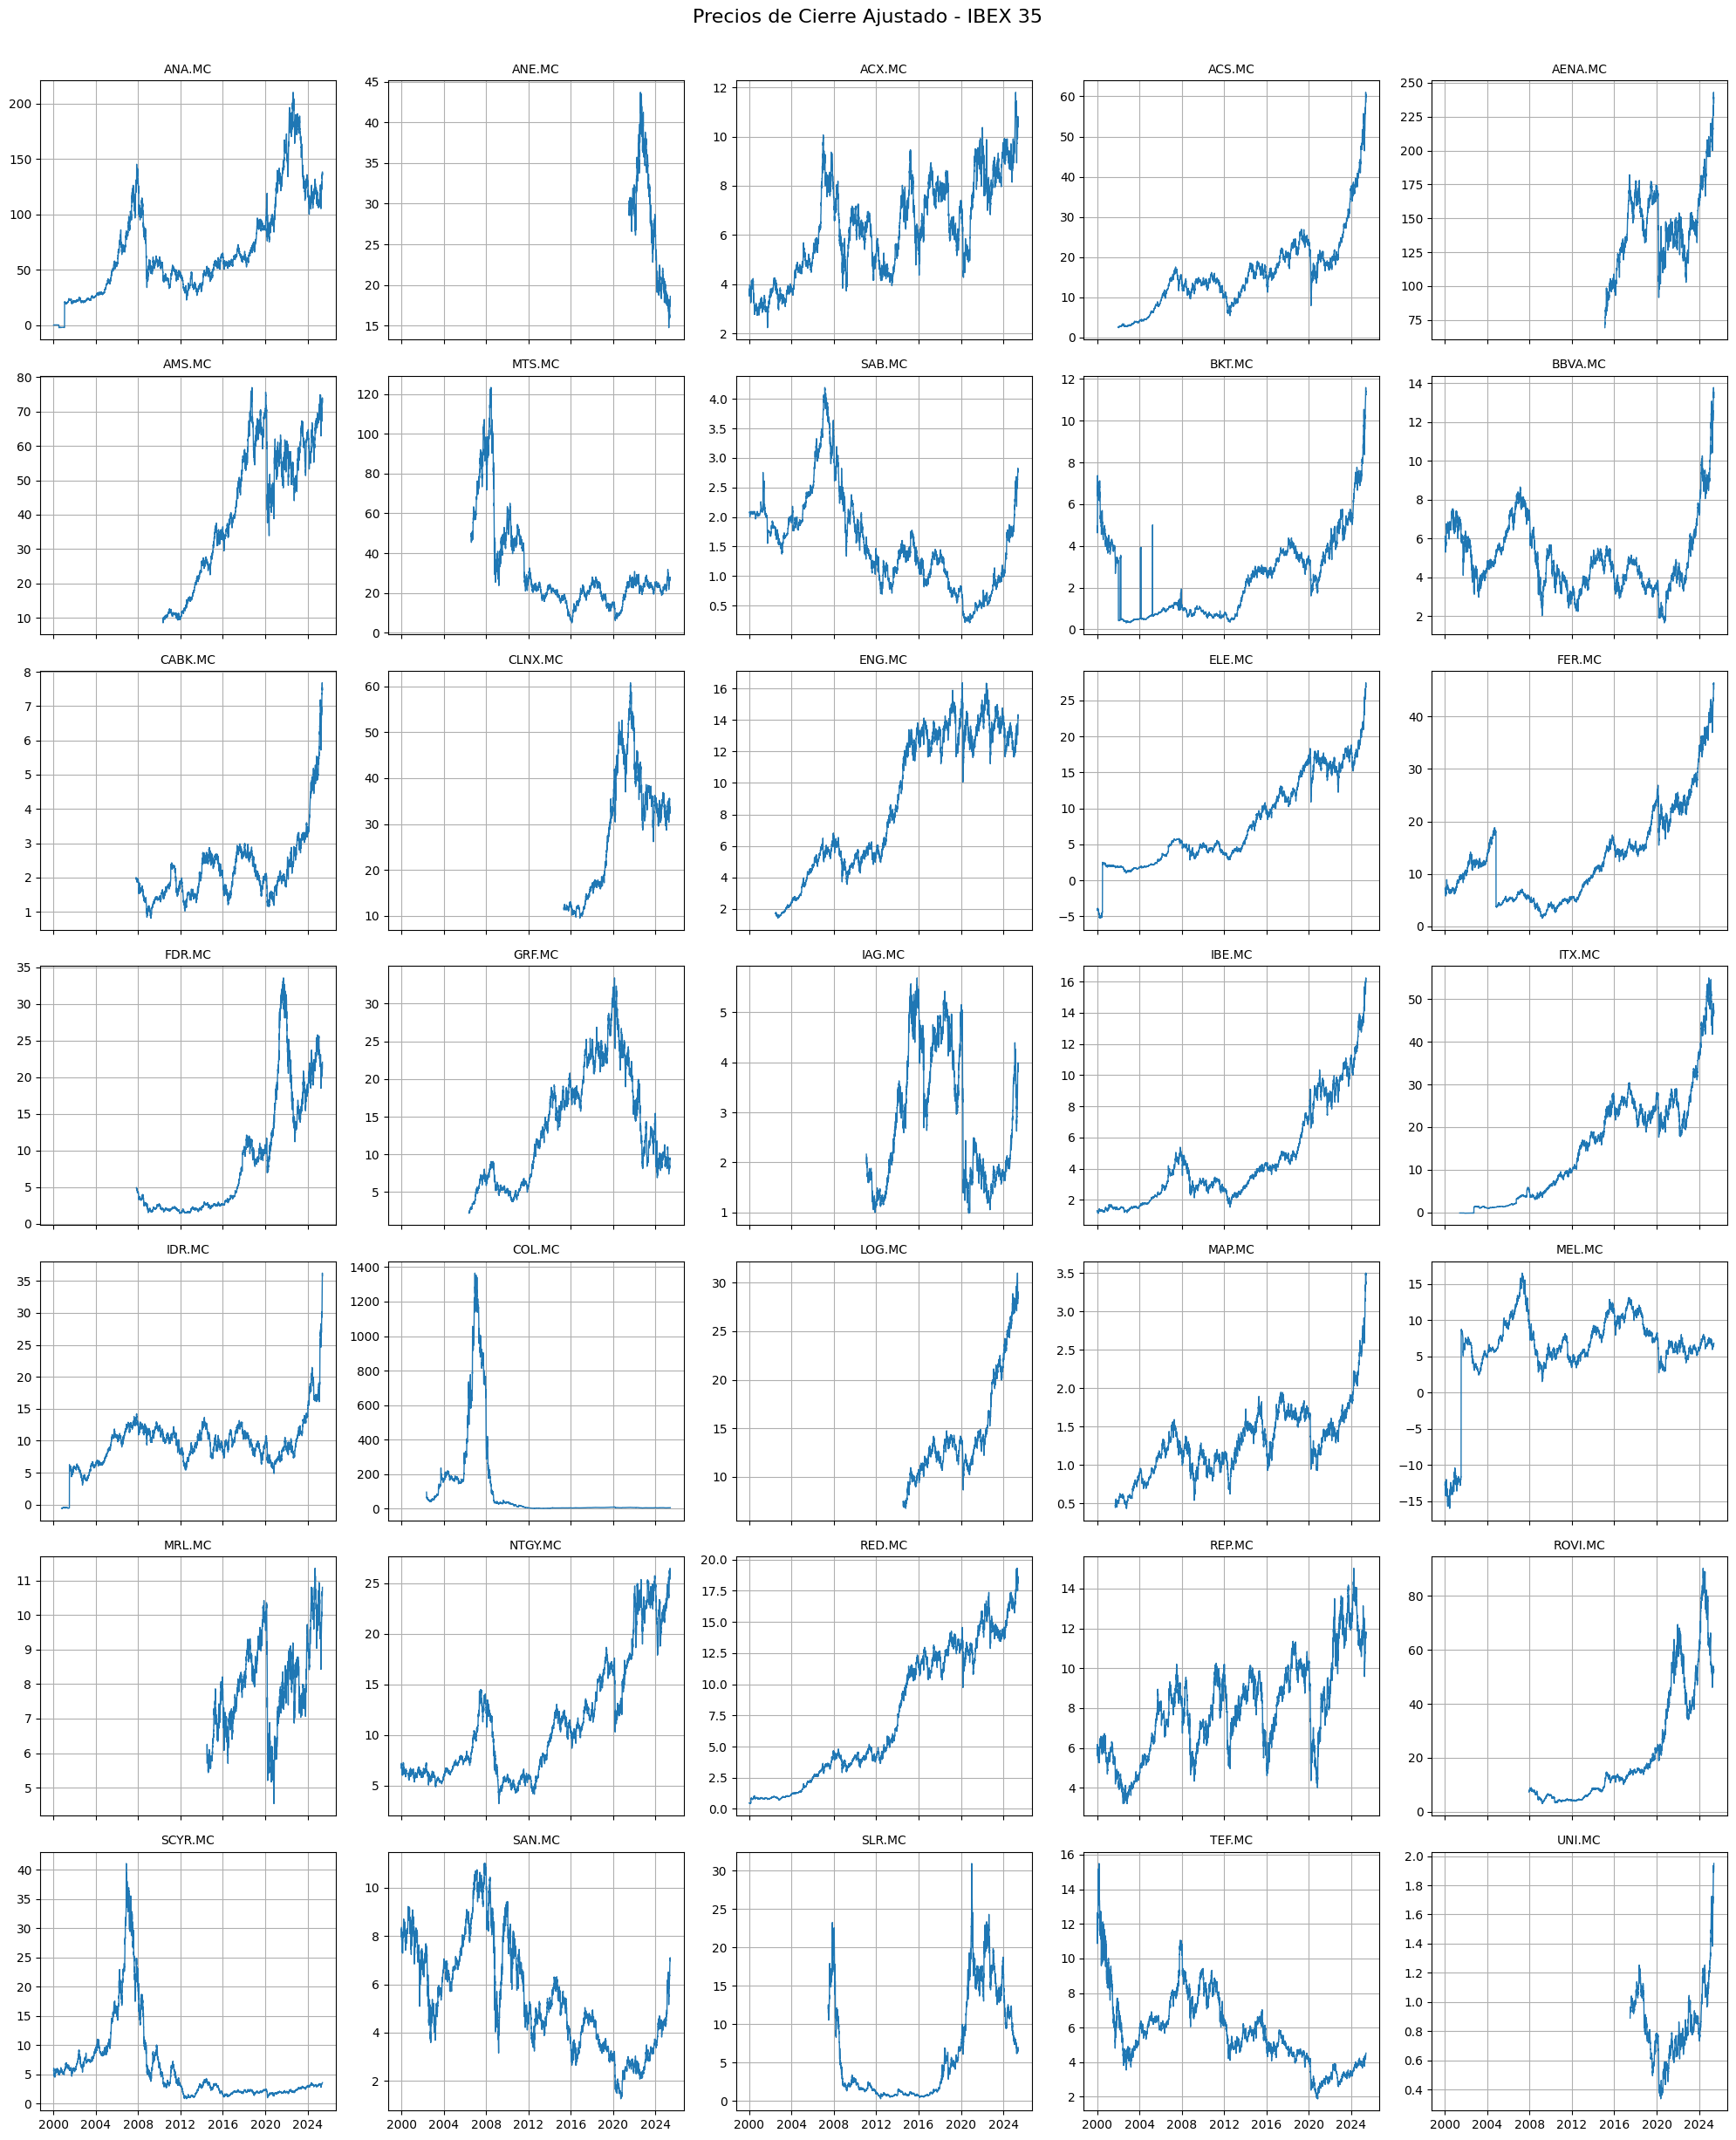

In [11]:
fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(20, 24), sharex=True)
axes = axes.flatten()  # Aplanamos la matriz para iterar fácilmente

# Graficar cada ticker
for i, ticker in enumerate(tickers):
    if ticker in data_full.columns.get_level_values(0):
        serie = data_full[ticker]['Close'].dropna()
        axes[i].plot(serie, linewidth=1)
        axes[i].set_title(ticker, fontsize=10)
        axes[i].grid(True)
    else:
        axes[i].set_visible(False)  # Si no hay datos, ocultamos el subplot

# Ajustes generales
plt.tight_layout()
plt.suptitle("Precios de Cierre Ajustado - IBEX 35", fontsize=16, y=1.02)
plt.show()

Vamos a revisar que tickers tienen datos desde el 2015 y volveremos a realizar la descarga para estos, no filtraremos data_full dado que el multi-index puede causarnos problemas y de esta manera evitamos errores.

In [12]:
# Fecha mínima aceptada
fecha_corte = datetime(2015, 1, 1)

# Lista para guardar los válidos
tickers_filtrados = []

# Verificar la fecha mínima por ticker
for ticker in tickers:
    if ticker in data_full.columns.get_level_values(0):
        primera_fecha = data_full[ticker].dropna().index.min()
        if primera_fecha <= fecha_corte:
            tickers_filtrados.append(ticker)

# Mostrar resultados
print(f"Número de activos con datos desde 2015 o antes: {len(tickers_filtrados)}")
print("Tickers seleccionados:")
print(tickers_filtrados)


Número de activos con datos desde 2015 o antes: 31
Tickers seleccionados:
['ANA.MC', 'ACX.MC', 'ACS.MC', 'AMS.MC', 'MTS.MC', 'SAB.MC', 'BKT.MC', 'BBVA.MC', 'CABK.MC', 'ENG.MC', 'ELE.MC', 'FER.MC', 'FDR.MC', 'GRF.MC', 'IAG.MC', 'IBE.MC', 'ITX.MC', 'IDR.MC', 'COL.MC', 'LOG.MC', 'MAP.MC', 'MEL.MC', 'MRL.MC', 'NTGY.MC', 'RED.MC', 'REP.MC', 'ROVI.MC', 'SCYR.MC', 'SAN.MC', 'SLR.MC', 'TEF.MC']


Volvemos a descargar

In [13]:
data_ibex = yf.download(
    tickers=tickers_filtrados,
    start="2015-01-01",
    end="2025-05-30",
    interval="1d",
    group_by="ticker",
    auto_adjust=True,
    actions=False,
    threads=True,
    progress=True
)

# Guardar a CSV
data_ibex.to_csv("IBEX_DATA_2015.csv", index=True)

# Mostrar muestra de un ticker
print(data_ibex[tickers_filtrados[0]].head())

[*********************100%***********************]  31 of 31 completed


Price            Open       High        Low      Close  Volume
Date                                                          
2015-01-02  39.348962  39.951984  38.849908  39.543037  196087
2015-01-05  39.161814  39.958914  38.018149  38.135983  160397
2015-01-06  38.461760  38.461760  36.929942  37.595348  144717
2015-01-07  37.803284  38.468687  37.491375  37.865665  171249
2015-01-08  38.565728  40.062888  38.170645  39.806431  204264


Carga de los datos sin necesidad de recurrir a la descarga

In [14]:
data_ibex = pd.read_csv("IBEX_DATA_2015.csv", index_col=0, parse_dates=[0], header=[0,1])

# Procesado de los Datos

### Preprocesamiento:

En esta función de preprocesado preparo los datos históricos del precio para que el modelo pueda intentar **predecir la dirección del mercado (subida o bajada)** en base al comportamiento reciente.

Los pasos son los siguientes:

1. **Cálculo de retornos logarítmicos**: se calcula el cambio relativo diario en el precio usando logaritmos, lo cual suaviza los movimientos y facilita el trabajo del modelo.

   $$ \text{retorno}_t = \log\left(\frac{P_t}{P_{t-1}}\right) $$

2. **Generación de lags**: se crean como variables los retornos de los últimos días. Por ejemplo, si usamos 5 lags, el modelo tendrá como entrada los retornos de los últimos 5 días para intentar predecir la dirección del siguiente.

3. **Eliminación de valores nulos**: los lags generan NaNs al principio del dataset, que se eliminan.

4. **División en entrenamiento y test**: se parte la serie en dos conjuntos (por defecto, 70% para entrenamiento y 30% para test), manteniendo el orden temporal (sin mezclar los datos).

5. **Estandarización**: se normalizan los datos (media 0, desviación estándar 1) con `StandardScaler` para que todas las variables tengan la misma escala y el modelo no se vea influenciado por magnitudes diferentes.

Este enfoque permite que un modelo sencillo como una regresión lineal intente **predecir la dirección del movimiento del activo**, lo que luego se traduce en una estrategia que entra largo si la predicción es positiva, o entra corto si es negativa.


In [15]:
def preprocess(df):
    df = df.copy()
    df["returns"] = np.log(df["Close"] / df["Close"].shift(1))
    for i in range(1, 6):
        df[f"Lag_{i}"] = df["returns"].shift(i)
    df.dropna(inplace=True)
    
    # Split temporal
    X = df[[f"Lag_{i}" for i in range(1, 6)]]
    y = df["returns"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.3, random_state=0)
    
    return X_train, X_test, y_train, y_test, df

# SMOKE TEST

Vamos a seleccionar 5 tickers de manera aleatoria para hacer un smoke test, usando un modelo de regresión linal y poder así optimizar el procesado.

In [ ]:
def smoke_test(preprocessing_func, data=data_ibex, tickers = tickers_filtrados, n=5):
    """
    Smoke test long-only que incluye:
      - Correlación de X_train
      - R² en test
      - Número de operaciones
      - Rentabilidades y gráficas
      - Medias finales
    """
    np.random.seed(42)
    selected = np.random.choice(tickers, n, replace=False)
    print("Tickers seleccionados:", selected)

    strat_returns = []
    hold_returns  = []
    r2_scores     = []

    for ticker in selected:
        df = data[ticker].copy()
        X_train, X_test, y_train, y_test, df_proc, *extras = preprocessing_func(df)

        # 1) Matriz de correlación
        plt.figure(figsize=(8, 6))
        sns.heatmap(X_train.corr(), annot=True, cmap="coolwarm", fmt=".2f")
        plt.title(f"Matriz de correlación – {ticker}")
        plt.show()

        # 2) Entrenar y predecir
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # 3) R² en test
        r2 = r2_score(y_test, y_pred)
        r2_scores.append(r2)

        # 4) Señal long-only y acumulado
        
        df_test = df_proc.loc[X_test.index].copy()              
        df_test['pred']      = y_pred
        df_test['signal']    = (df_test['pred'] > 0).astype(int)
        df_test['strat_ret'] = df_test['signal'].shift(1) * df_test['returns']  # <- shift(1)
        df_test['cum_hold']  = np.exp(df_test['returns'].cumsum())
        df_test['cum_strat'] = np.exp(df_test['strat_ret'].cumsum())
        df_test['chg']       = df_test['signal'].diff().fillna(0)

        num_trades = int((df_test['chg'] != 0).sum())
        sret       = df_test['cum_strat'].iloc[-1]
        hret       = df_test['cum_hold'].iloc[-1]
        strat_returns.append(sret)
        hold_returns.append(hret)

        print(f"\nTicker: {ticker}")
        print(f"- R² test:                 {r2:.4f}")
        print(f"- Número de operaciones:   {num_trades}")
        print(f"- Estrategia (final):      {sret:.4f}")
        print(f"- Buy & Hold (final):      {hret:.4f}")

        # 5) Grafica capital
        plt.figure(figsize=(10, 5))
        plt.plot(df_test.index, df_test['cum_hold'],  label="Buy & Hold")
        plt.plot(df_test.index, df_test['cum_strat'], label="Estrategia")
        plt.title(f"Crecimiento de capital – {ticker}")
        plt.xlabel("Fecha"); plt.ylabel("Capital (base=1)")
        plt.legend(); plt.grid(True)
        plt.show()

    # 6) Medias finales
    print("\n=== Medias sobre", n, "tickers ===")
    print(f"R² medio:                    {np.mean(r2_scores):.4f}")
    print(f"Estrategia media:            {np.mean(strat_returns):.4f}")
    print(f"Buy & Hold medio:            {np.mean(hold_returns):.4f}")

Vemos el desempeño de los datos preprocesados en el smoke test

Tickers seleccionados: ['SCYR.MC' 'IBE.MC' 'NTGY.MC' 'IDR.MC' 'CABK.MC']


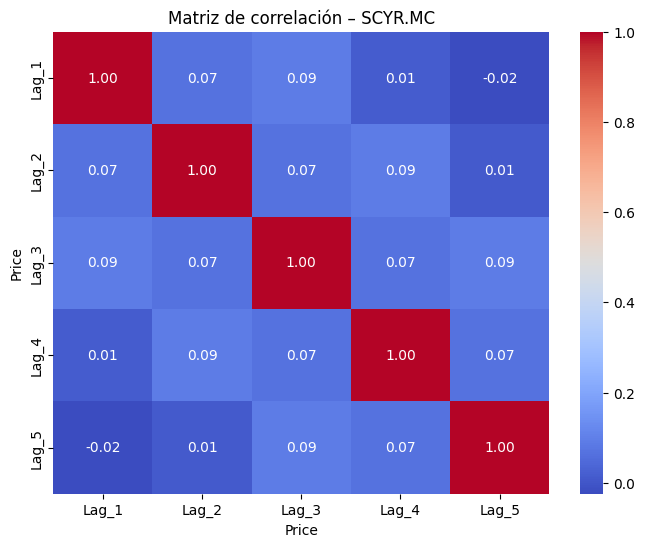


Ticker: SCYR.MC
- R² test:                 -0.0250
- Número de operaciones:   322
- Estrategia (final):      0.9974
- Buy & Hold (final):      1.6421


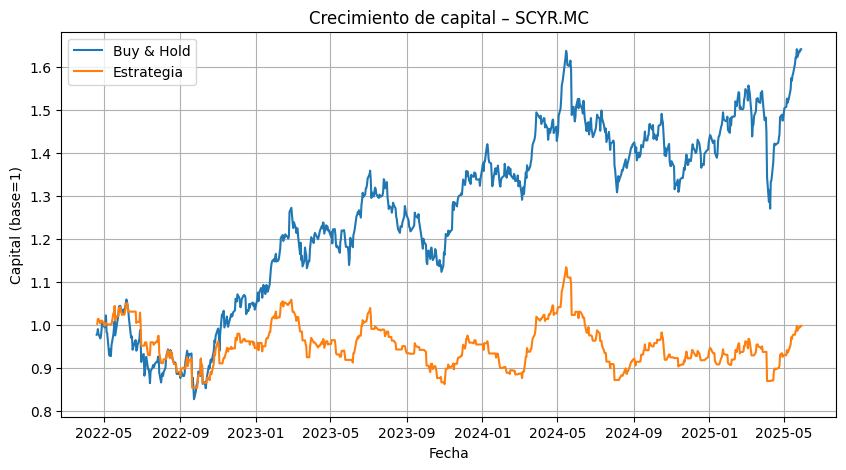

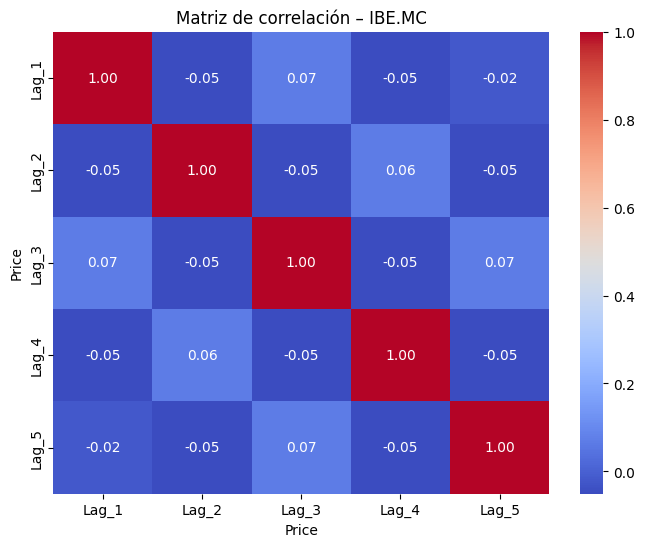


Ticker: IBE.MC
- R² test:                 -0.0122
- Número de operaciones:   388
- Estrategia (final):      1.4156
- Buy & Hold (final):      1.7381


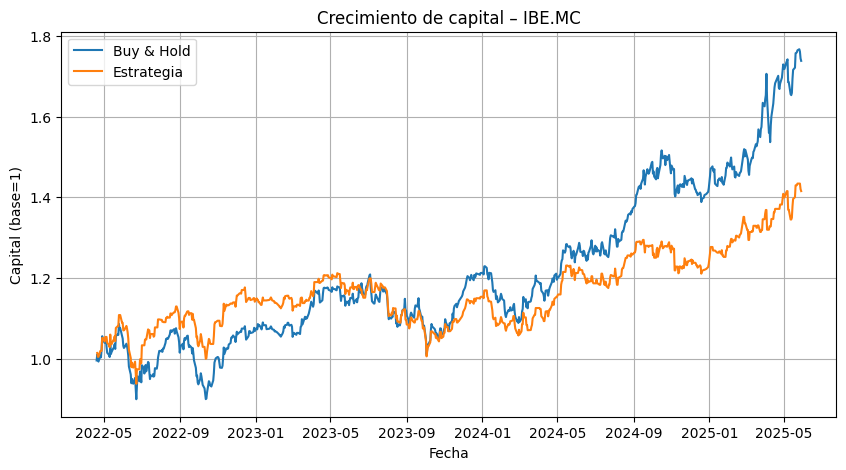

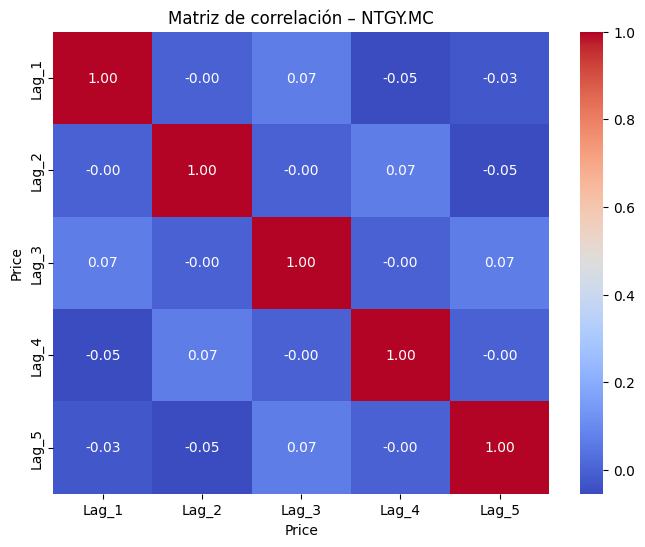


Ticker: NTGY.MC
- R² test:                 -0.0098
- Número de operaciones:   378
- Estrategia (final):      0.8209
- Buy & Hold (final):      1.0345


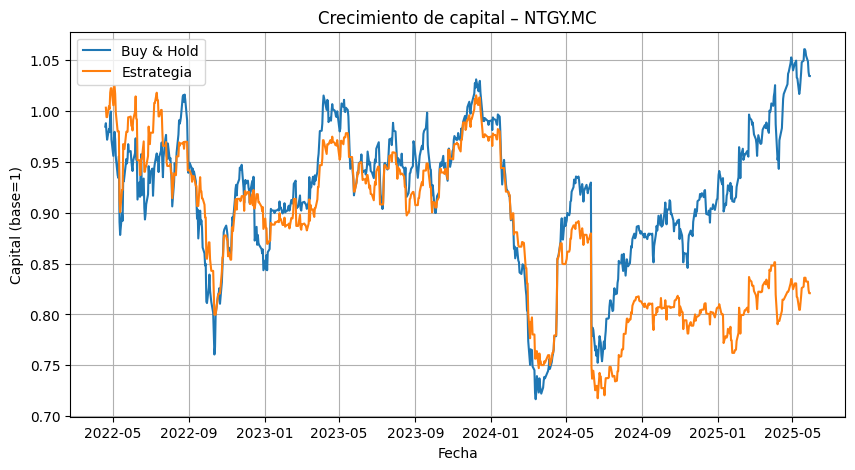

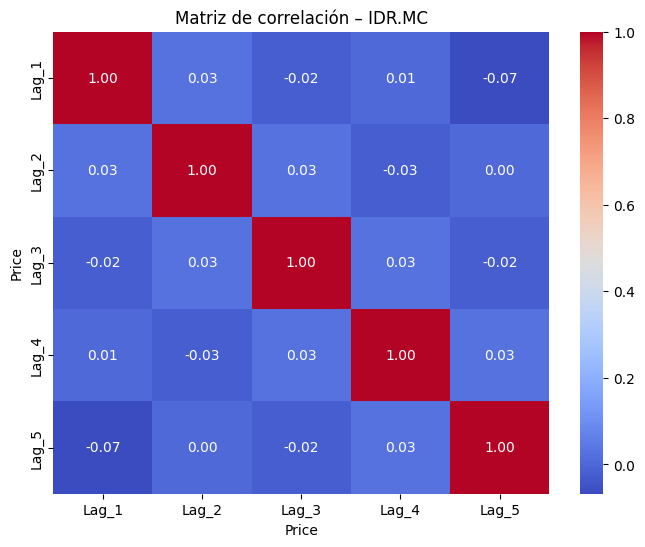


Ticker: IDR.MC
- R² test:                 -0.0257
- Número de operaciones:   373
- Estrategia (final):      1.7582
- Buy & Hold (final):      4.1034


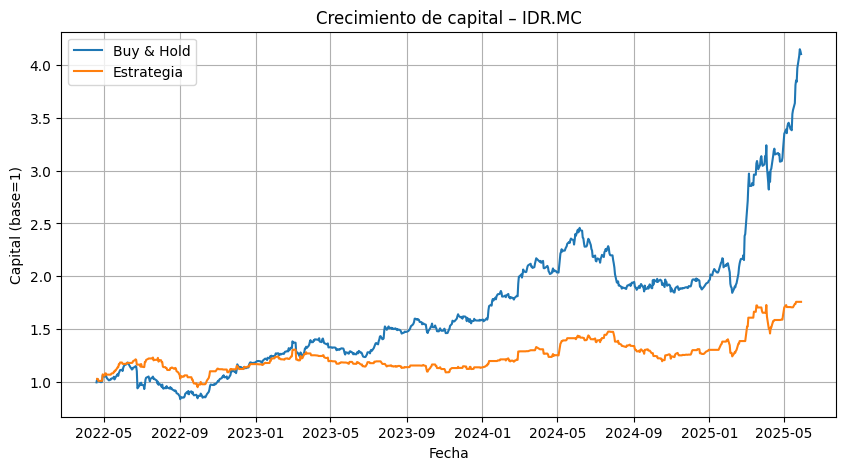

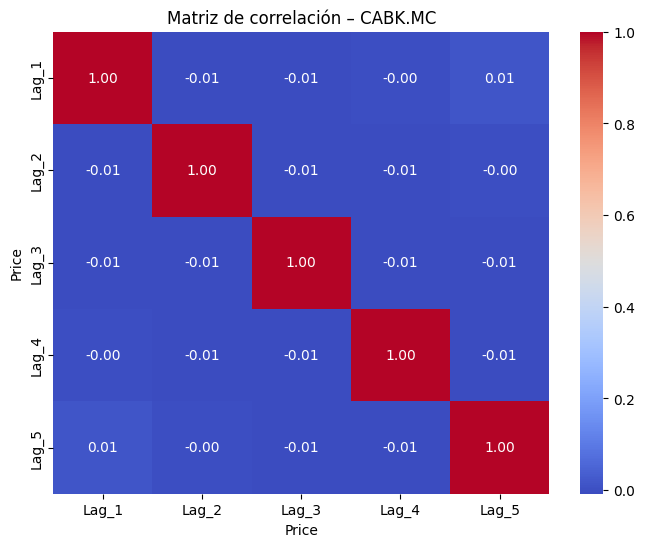


Ticker: CABK.MC
- R² test:                 -0.0061
- Número de operaciones:   372
- Estrategia (final):      1.2332
- Buy & Hold (final):      3.0607


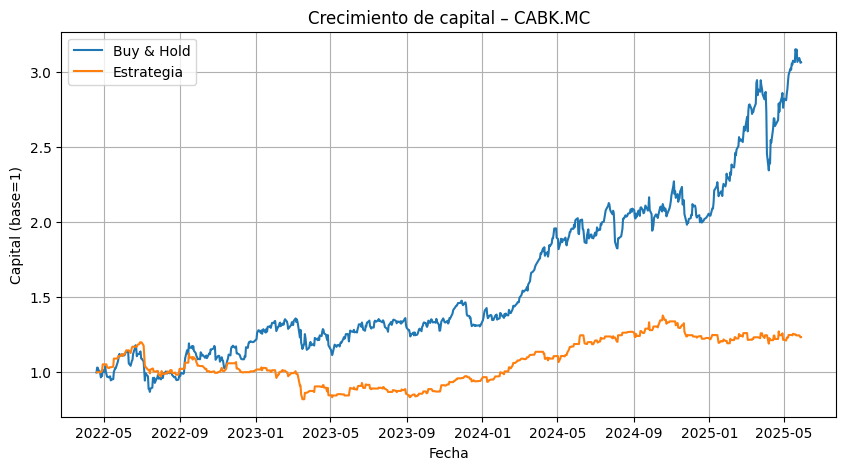


=== Medias sobre 5 tickers ===
R² medio:                    -0.0157
Estrategia media:            1.2451
Buy & Hold medio:            2.3157


In [17]:
smoke_test(preprocess)

La estrategia básica (R² medio –0.016) rinde ×1.33 vs ×2.30 de Buy & Hold. Añadimos variables técnicas y PCA para reducir dimensionalidad:

**Variables:**
- `returns`: log-retorno diario  
- `Lag_1`…`Lag_5`: retornos de 1–5 días previos  
- `mom5`: momentum a 5 días  
- `mom10`: momentum a 10 días  
- `range_prev`: rango intradía del día anterior  
- `gap_prev`: gap de apertura  
- `TR`: true range intradía  
- `up`, `down`: componentes positivas/negativas de variación  
- `mean_15`, `mean_60`: media móvil de retornos 15/60 días  
- `vol_15`, `vol_60`: volatilidad de retornos 15/60 días  
- `bb_w15`, `bb_w60`: ancho de Bollinger 15/60 días  
- `ATR14`: promedio de TR en 14 días  
- `RSI14`: índice de fuerza relativa 14 días  
- `vol_norm15`: volumen normalizado sobre media 15 días  

Usamos PCA para conservar ~80 % de la varianza con menos componentes, sacrificando algo de interpretabilidad.

In [11]:
def advanced_preprocess(
    df,
    variance_threshold=0.8
):
    """
    Pipeline de preprocesado y PCA automático para datos OHLCV de un solo ticker.

    Pasos:
    1) Genera features técnicas (retornos, momentum, rangos, volúmenes, ATR, RSI, etc.) sin filtración futura.
    2) Split temporal 70% train / 30% test.
    3) Calcula rolling features en train y en test.
    4) Escala features con StandardScaler entrenado en train y devuelve también features escaladas crudas.
    5) Aplica PCA completo y determina automáticamente n_components para cubrir `variance_threshold`.
    6) Genera un scree plot en memoria y una matriz de cargas como DataFrame.

    Args:
        df (pd.DataFrame): con columnas ['Open','High','Low','Close','Volume'] y DateTimeIndex.
        variance_threshold (float): umbral de varianza acumulada (0-1) para seleccionar componentes.

    Returns:
        X_train_pca (pd.DataFrame): componentes PCA para entrenamiento.
        X_test_pca  (pd.DataFrame): componentes PCA para test.
        y_train     (pd.Series): retornos de train.
        y_test      (pd.Series): retornos de test.
        df_processed (pd.DataFrame): DataFrame preprocesado completo (train+test) con columna 'returns'.
        X_train_raw (pd.DataFrame): features escaladas (sin PCA) para entrenamiento.
        X_test_raw  (pd.DataFrame): features escaladas (sin PCA) para test.
        loadings    (pd.DataFrame): matriz de cargas (features x componentes).
        scree_fig   (matplotlib.figure.Figure): figura del scree plot (varianza explicada y acumulada).
    """
    # 1) Generar features
    df_proc = df.copy()
    df_proc.index = pd.to_datetime(df_proc.index)
    df_proc.sort_index(inplace=True)

    df_proc['returns'] = np.log(df_proc['Close'] / df_proc['Close'].shift(1))
    for i in range(1, 6):
        df_proc[f'Lag_{i}'] = df_proc['returns'].shift(i)
    df_proc['range_prev'] = (df_proc['High'].shift(1) - df_proc['Low'].shift(1)) / df_proc['Close'].shift(1)
    df_proc['gap_prev']   = (df_proc['Open'] - df_proc['Close'].shift(1)) / df_proc['Close'].shift(1)
    df_proc['mom5']       = df_proc['Close'].shift(1) / df_proc['Close'].shift(6) - 1
    df_proc['mom10']      = df_proc['Close'].shift(1) / df_proc['Close'].shift(11) - 1

    tr1 = df_proc['High'] - df_proc['Low']
    tr2 = (df_proc['High'] - df_proc['Close'].shift(1)).abs()
    tr3 = (df_proc['Low'] - df_proc['Close'].shift(1)).abs()
    df_proc['TR'] = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

    delta = df_proc['Close'].diff()
    df_proc['up']   = delta.clip(lower=0)
    df_proc['down'] = -delta.clip(upper=0)

    base_cols = ['returns'] + [f'Lag_{i}' for i in range(1, 6)] + [
        'range_prev', 'gap_prev', 'mom5', 'mom10', 'TR', 'up', 'down'
    ]
    df_proc.dropna(subset=base_cols, inplace=True)

    # 2) Split temporal
    split_idx = int(0.7 * len(df_proc))
    df_train = df_proc.iloc[:split_idx].copy()
    df_test  = df_proc.iloc[split_idx:].copy()

    # 3) Rolling features
    for w in (15, 60):
        df_train[f'mean_{w}'] = df_train['returns'].rolling(w).mean().shift(1)
        df_train[f'vol_{w}']  = df_train['returns'].rolling(w).std().shift(1)
        df_train[f'bb_w{w}']  = df_train[f'vol_{w}'] / (df_train[f'mean_{w}'].abs() + 1e-6)
    df_train['ATR14'] = df_train['TR'].rolling(14).mean().shift(1)
    ma_up   = df_train['up'].rolling(14).mean().shift(1)
    ma_down = df_train['down'].rolling(14).mean().shift(1)
    df_train['RSI14'] = 100 - 100 / (1 + ma_up / (ma_down + 1e-6))
    df_train['vol_norm15'] = df_train['Volume'].shift(1) / (
        df_train['Volume'].rolling(15).mean().shift(1) + 1e-6
    )

    # Combinar para cálculo en test
    max_w = max(60, 14, 15)
    comb = pd.concat([df_train.tail(max_w), df_test])
    for w in (15, 60):
        comb[f'mean_{w}'] = comb['returns'].rolling(w).mean().shift(1)
        comb[f'vol_{w}']  = comb['returns'].rolling(w).std().shift(1)
        comb[f'bb_w{w}']  = comb[f'vol_{w}'] / (comb[f'mean_{w}'].abs() + 1e-6)
    comb['ATR14']   = comb['TR'].rolling(14).mean().shift(1)
    mu_up   = comb['up'].rolling(14).mean().shift(1)
    mu_down = comb['down'].rolling(14).mean().shift(1)
    comb['RSI14']  = 100 - 100 / (1 + mu_up / (mu_down + 1e-6))
    comb['vol_norm15'] = comb['Volume'].shift(1) / (
        comb['Volume'].rolling(15).mean().shift(1) + 1e-6
    )
    df_test = comb.loc[df_test.index].copy()

    df_train.dropna(inplace=True)
    df_test.dropna(inplace=True)

    # 4) Escalado de features
    features = [
        f'Lag_{i}' for i in range(1, 6)
    ] + [
        'range_prev', 'gap_prev', 'mom5', 'mom10'
    ] + [
        f'mean_{w}' for w in (15, 60)
    ] + [
        f'vol_{w}' for w in (15, 60)
    ] + [
        f'bb_w{w}' for w in (15, 60)
    ] + [
        'ATR14', 'RSI14', 'vol_norm15'
    ]
    X_train = df_train[features]
    y_train = df_train['returns']
    X_test  = df_test[features]
    y_test  = df_test['returns']

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)
    X_train_raw = pd.DataFrame(X_train_scaled, index=X_train.index, columns=features)
    X_test_raw  = pd.DataFrame(X_test_scaled,  index=X_test.index,  columns=features)

    # 5) PCA y selección de componentes
    pca_full = PCA(n_components=X_train_scaled.shape[1])
    pca_full.fit(X_train_scaled)
    evr = pca_full.explained_variance_ratio_
    cum_evr = np.cumsum(evr)
    opt_n = int(np.argmax(cum_evr >= variance_threshold) + 1)

    # 6) Scree plot en memoria
    fig, ax = plt.subplots(figsize=(10, 6))
    comps = np.arange(1, len(evr) + 1)
    ax.bar(comps, evr, alpha=0.7)
    ax2 = ax.twinx()
    ax2.plot(comps, cum_evr, marker='o')
    ax.axhline(variance_threshold, color='r', linestyle='--')
    ax.axvline(opt_n, color='g', linestyle='--')
    ax.set_xlabel('Componente')
    ax.set_ylabel('Varianza explicada')
    ax2.set_ylabel('Varianza acumulada')
    ax.set_title('Scree plot y varianza acumulada')
    fig.tight_layout()

    # 7) Transformación final con PCA
    pca = PCA(n_components=opt_n)
    X_train_p = pca.fit_transform(X_train_scaled)
    X_test_p  = pca.transform(X_test_scaled)
    pc_cols = [f'PC_{i+1}' for i in range(opt_n)]
    X_train_pca = pd.DataFrame(X_train_p, index=X_train.index, columns=pc_cols)
    X_test_pca  = pd.DataFrame(X_test_p,  index=X_test.index,  columns=pc_cols)

    # 8) Matriz de cargas
    loadings = pd.DataFrame(
        pca.components_.T,
        index=features,
        columns=pc_cols
    )

    # 9) DataFrame completo con 'returns'
    df_processed = pd.concat([df_train, df_test])

    # Return compatible with smoke_test
    return X_train_pca, X_test_pca, y_train, y_test, df_processed, X_train_raw, X_test_raw, loadings, fig

Tickers seleccionados: ['SCYR.MC' 'IBE.MC' 'NTGY.MC' 'IDR.MC' 'CABK.MC']


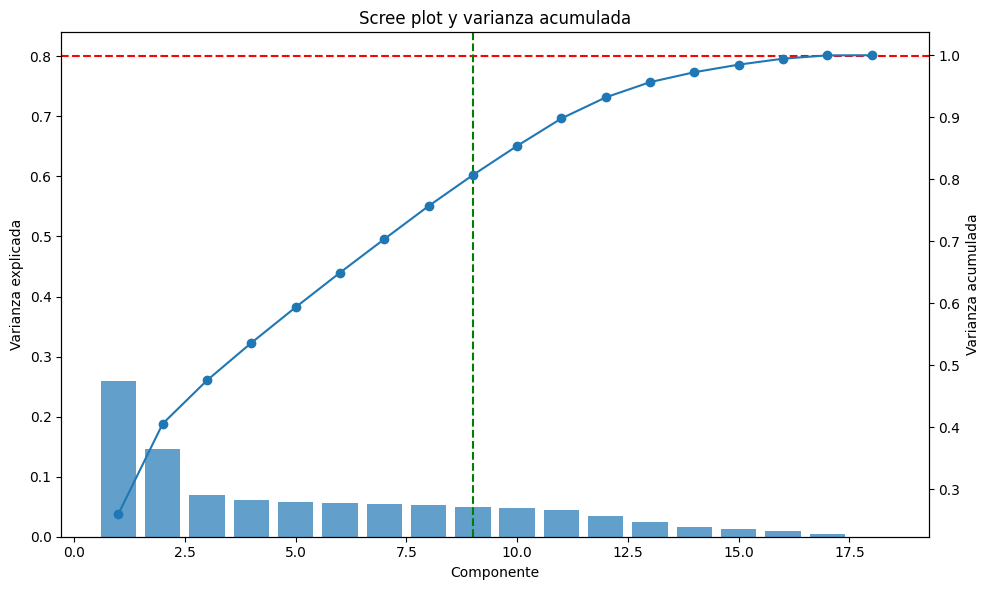

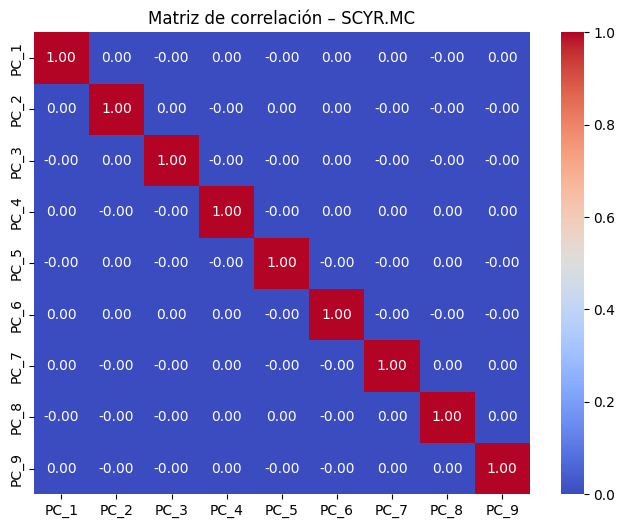


Ticker: SCYR.MC
- R² test:                 0.0921
- Número de operaciones:   354
- Estrategia (final):      5.1064
- Buy & Hold (final):      1.6042


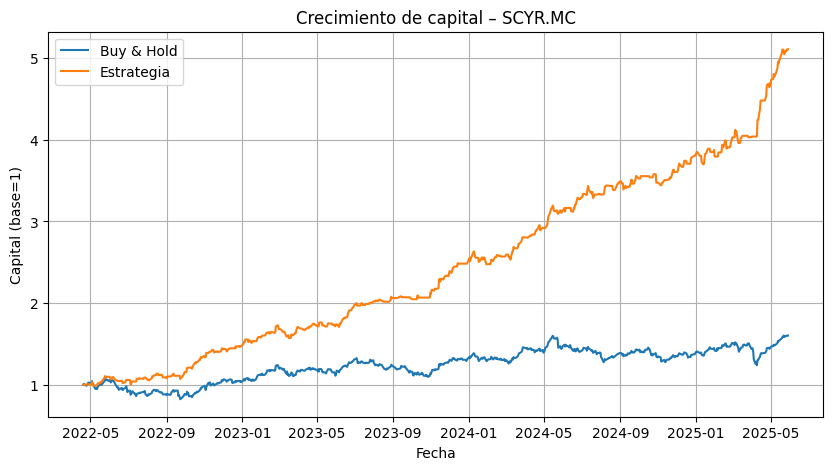

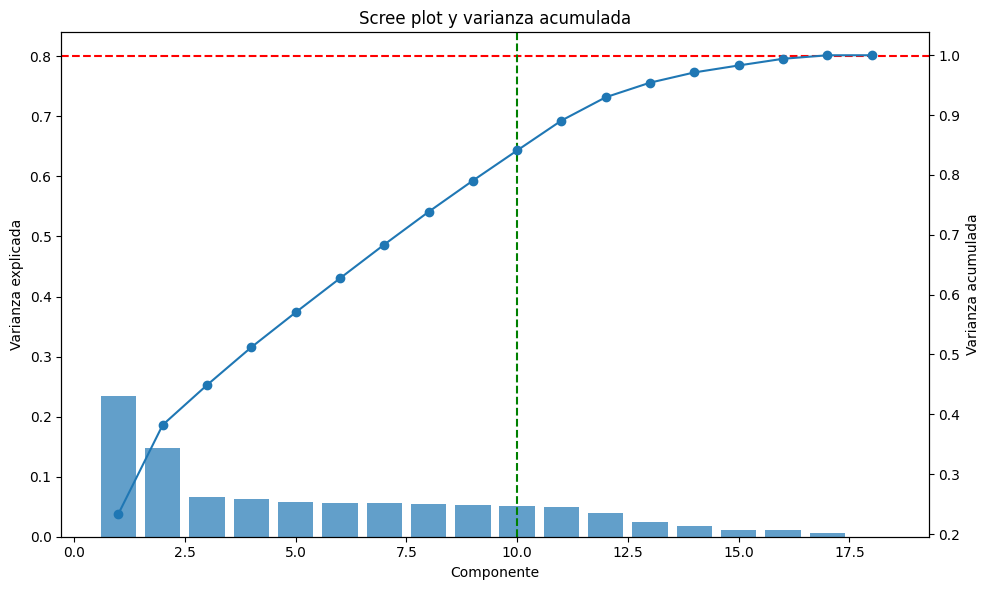

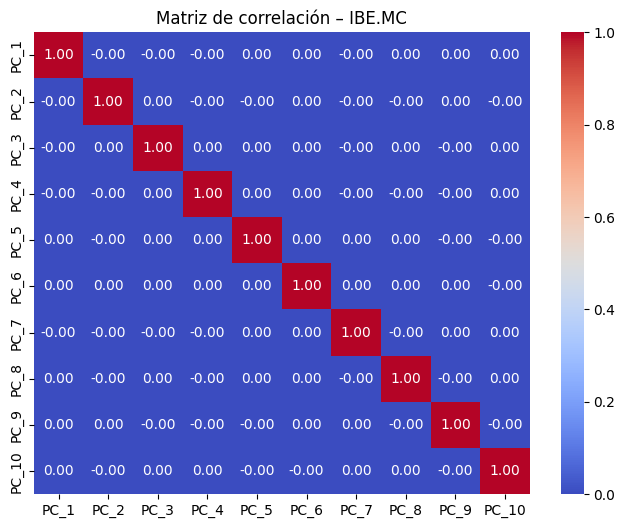


Ticker: IBE.MC
- R² test:                 0.1692
- Número de operaciones:   379
- Estrategia (final):      5.0685
- Buy & Hold (final):      1.7476


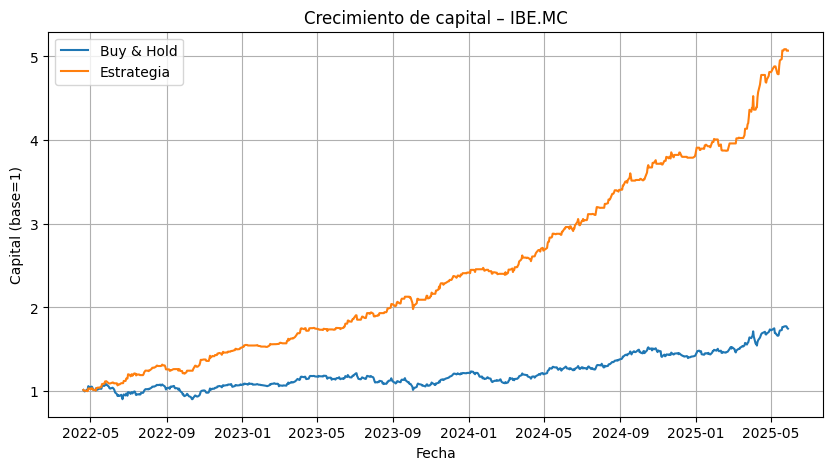

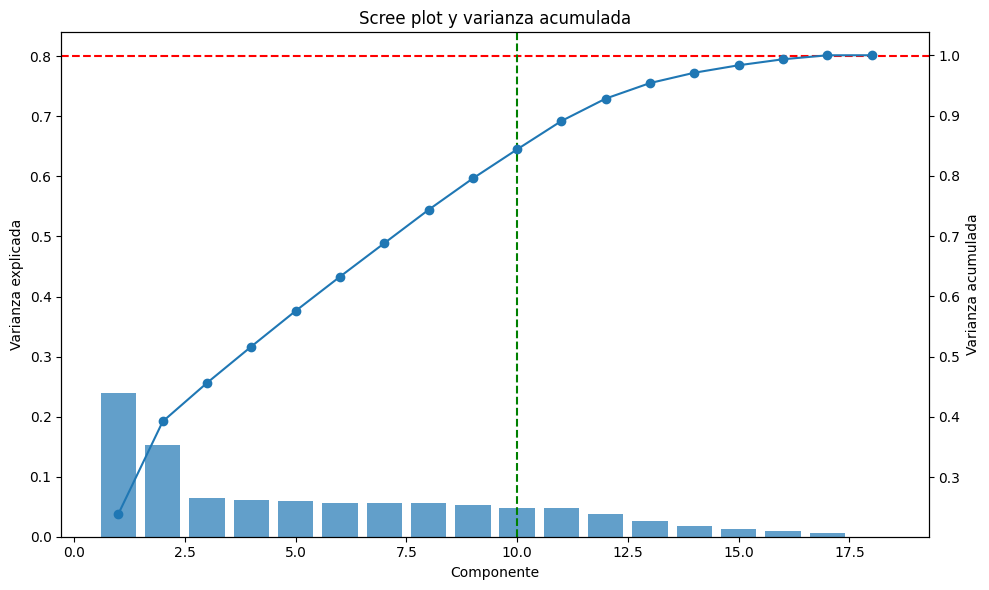

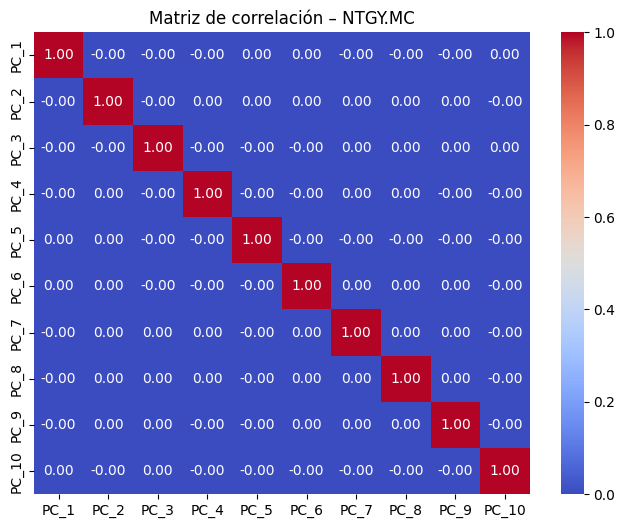


Ticker: NTGY.MC
- R² test:                 0.1661
- Número de operaciones:   334
- Estrategia (final):      2.9223
- Buy & Hold (final):      1.0505


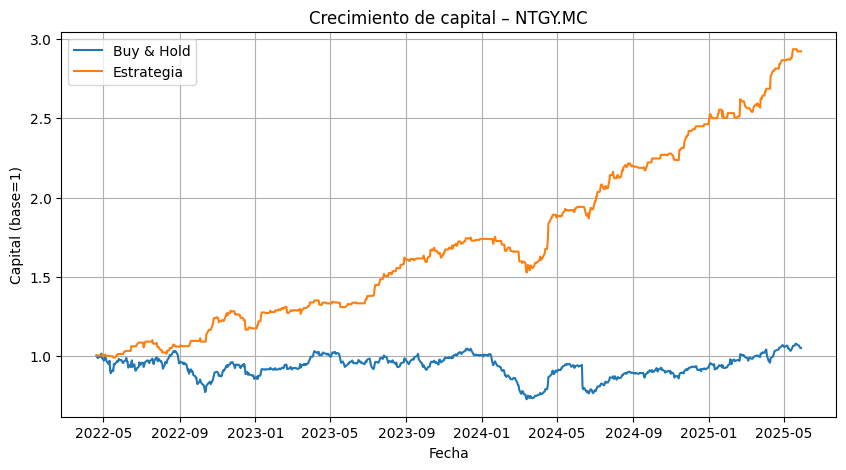

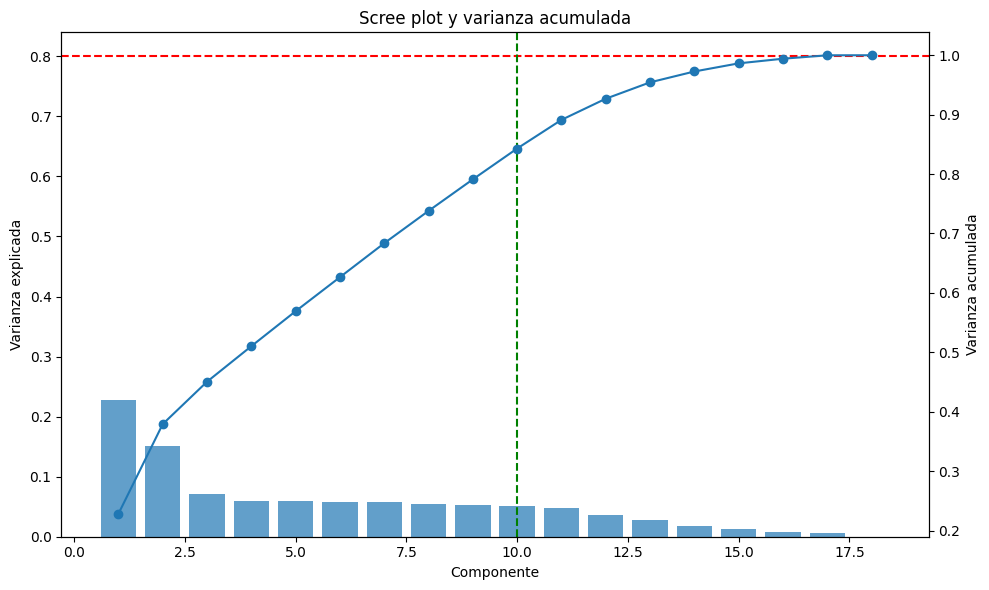

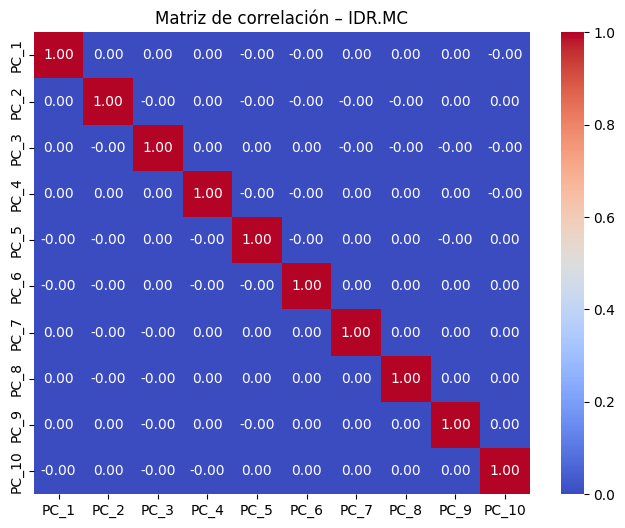


Ticker: IDR.MC
- R² test:                 0.0444
- Número de operaciones:   338
- Estrategia (final):      7.4926
- Buy & Hold (final):      4.1190


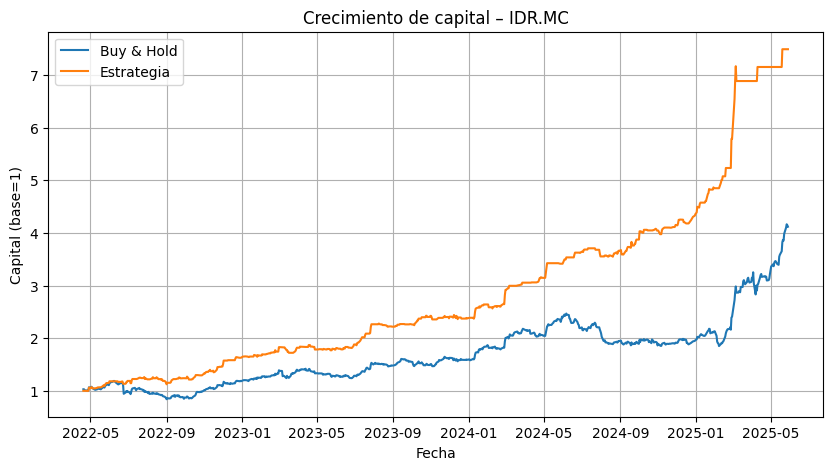

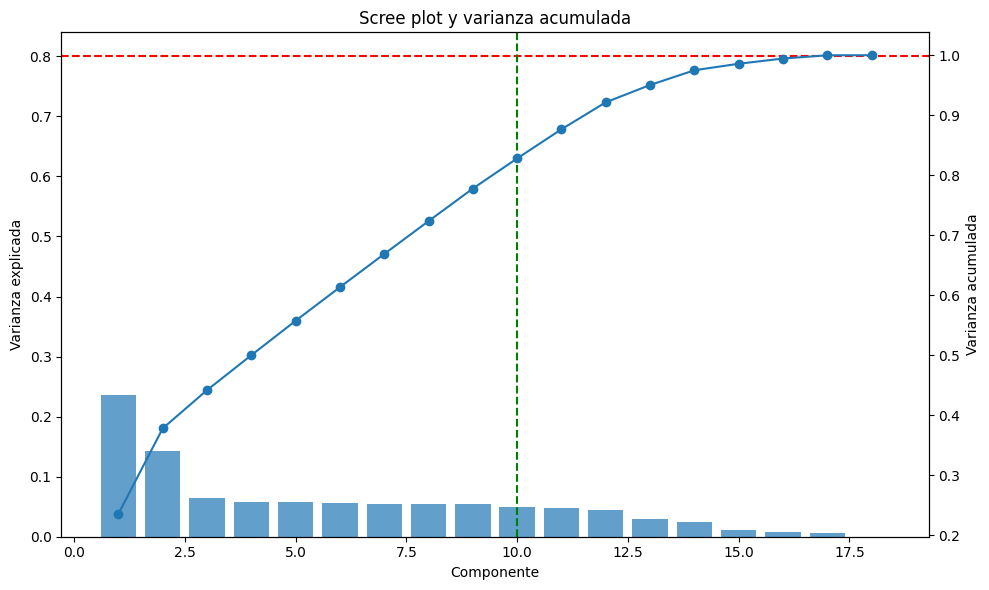

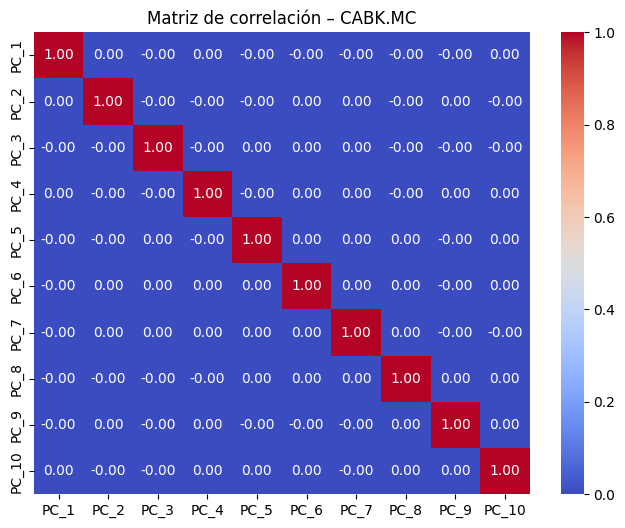


Ticker: CABK.MC
- R² test:                 0.0457
- Número de operaciones:   370
- Estrategia (final):      5.1497
- Buy & Hold (final):      3.0657


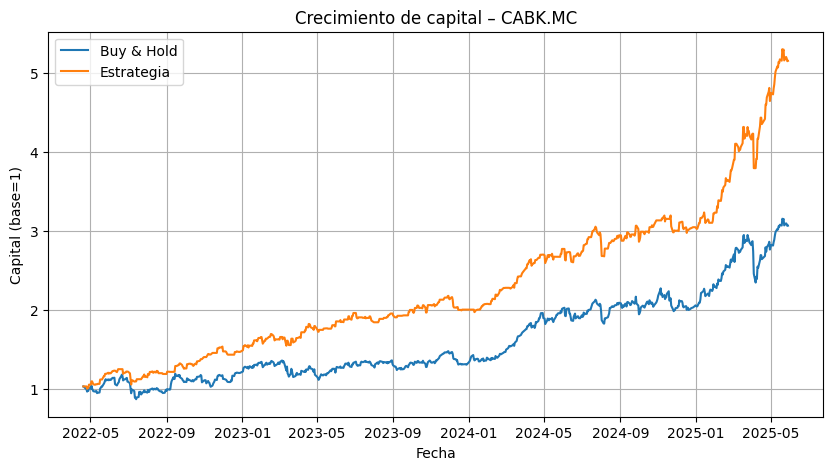


=== Medias sobre 5 tickers ===
R² medio:                    0.1035
Estrategia media:            5.1479
Buy & Hold medio:            2.3174


In [12]:
smoke_test(advanced_preprocess)

Se puede apreciar una mejora sustancial en los tickers, los resultados en media duplican al IBEX, este modelo es muy sencillo y estos resultados son dificilmente creibles,habra que introducir costes de trnasacción para hacerlo mas realista y penalizar el número de entradas y salidas en el mercado, y mejorar el entrenamiento para reducir el overfitting

# Automatización de estrategias & elección de activos

En esta sección se evalúan distintos modelos de regresión (lineales, árboles, SVR) para todos los activos filtrados.
Cada modelo es ajustado mediante búsqueda de hiperparámetros (Grid/RandomSearch) y se guardan los mejores modelos en disco. Finalmente, se seleccionan los activos con mejor desempeño para formar una cartera.

In [13]:
def tune_model(model, param_grid, X_train, y_train, cv_splits=5, randomized=False, n_iter=10, random_state=42, verbose=1):
    """
    Ajusta un modelo con GridSearchCV o RandomizedSearchCV usando TimeSeriesSplit.
    """
    tss = TimeSeriesSplit(n_splits=cv_splits)
    if randomized:
        search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grid,
            n_iter=n_iter,
            cv=tss,
            random_state=random_state,
            n_jobs=-1,
            verbose=verbose,
            pre_dispatch='2*n_jobs'
        )
    else:
        search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            cv=tss,
            n_jobs=-1,
            verbose=verbose,
            pre_dispatch='2*n_jobs'
        )
    search.fit(X_train, y_train)
    return search.best_estimator_

In [14]:
def backtest_regression(est, X_test, y_test, df_proc, cost_bps=0.0005):
    """
    Simula estrategia long-only con coste de transacción.
    """
    y_pred = est.predict(X_test)
    signal = (y_pred > 0).astype(int)
    df_test = df_proc.loc[X_test.index].copy()
    df_test['signal'] = signal
    df_test['signal_prev'] = df_test['signal'].shift(1).fillna(0)
    df_test['ret'] = df_test['returns']
    df_test['cost'] = cost_bps * df_test['signal_prev'].diff().abs().fillna(0)
    df_test['strat_ret'] = df_test['signal_prev'] * df_test['ret'] - df_test['cost']

    r2 = r2_score(y_test, y_pred)
    cum_returns = np.exp(df_test['strat_ret'].cumsum())
    total_return = cum_returns.iloc[-1]
    n_trades = int(df_test['signal_prev'].diff().abs().sum())
    mean_ret = df_test['strat_ret'].mean()
    std_ret = df_test['strat_ret'].std()
    sharpe = 0.0 if std_ret == 0 or np.isnan(std_ret) else mean_ret / std_ret * np.sqrt(252)
    drawdown = 1 - cum_returns / cum_returns.cummax()
    max_dd = drawdown.max()
    return {
        'R2_test': r2,
        'retorno_strat': total_return,
        'n_trades': n_trades,
        'sharpe': sharpe,
        'max_drawdown': max_dd
    }

In [15]:
def evaluate_models(data, tickers, cost_bps=0.0005, variance_threshold=0.8):
    """
    Evalúa varios regresores para cada ticker, guarda cada modelo entrenado en disco,
    y devuelve DataFrame con métricas:
    ticker | modelo | R2_test | retorno_strat | n_trades | sharpe | max_drawdown
    """
    # Directorio para almacenar los modelos entrenados
    models_dir = "models"
    os.makedirs(models_dir, exist_ok=True)

    results = []
    grids = {
        'LinearRegression': {
            'model': LinearRegression(),
            'params': {'fit_intercept': [True, False]},
            'randomized': False
        },
        'Ridge': {
            'model': Ridge(random_state=42),
            'params': {'alpha': [0.01, 0.1, 1, 10]},
            'randomized': False
        },
        'RandomForest': {
            'model': RandomForestRegressor(random_state=42),
            'params': {
                'n_estimators': [50, 100],
                'max_depth': [3, 5, 10, None],
                'min_samples_leaf': [1, 5],
                'max_features': ['sqrt', 'log2']
            },
            'randomized': False
        },
        'DecisionTree': {
            'model': DecisionTreeRegressor(random_state=42),
            'params': {
                'max_depth': [3, 5, 10, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 5, 10],
                'max_features': [None, 'sqrt', 'log2']
            },
            'randomized': False
        },
        'SVR': {
            'model': SVR(),
            'params': {
                'C': [0.01, 0.1, 1, 10],
                'kernel': ['linear', 'rbf', 'poly'],
                'gamma': ['scale', 'auto'],
                'degree': [2, 3],
                'epsilon': [0.01, 0.1, 1]
            },
            'randomized': True
        }
    }

    for ticker in tickers:
        # Desempaquetar raw y PCA
        X_train_pca, X_test_pca, y_train, y_test, df_proc, X_train_raw, X_test_raw, loadings, fig = \
            advanced_preprocess(data[ticker], variance_threshold=variance_threshold)
        plt.close(fig)

        for name, cfg in grids.items():
            # Elegir datos según modelo
            X_tr, X_te = (X_train_raw, X_test_raw) if name in ('DecisionTree', 'RandomForest') else (X_train_pca, X_test_pca)

            # Entrenar y ajustar
            best_est = tune_model(
                cfg['model'], cfg['params'], X_tr, y_train,
                randomized=cfg['randomized']
            )

            # Guardar el modelo entrenado
            model_filename = f"{ticker}_{name}.pkl"
            joblib.dump(best_est, os.path.join(models_dir, model_filename))

            # Backtest y métricas
            metrics = backtest_regression(best_est, X_te, y_test, df_proc, cost_bps)
            metrics['ticker'] = ticker
            metrics['modelo'] = name
            results.append(metrics)

    return pd.DataFrame.from_records(results)

In [16]:
# Ejecutar la evaluación de modelos
df_evaluacion = evaluate_models(data_ibex, tickers_filtrados)

# Guardar la tabla en CSV
df_evaluacion.to_csv('resultados_evaluacion_modelos.csv', index=False)

# (Opcional) También puedes guardarla en pickle para conservar tipos:
df_evaluacion.to_pickle('resultados_evaluacion_modelos.pkl')

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for ea

In [17]:
# Ajusta las opciones de visualización para evitar que Pandas no trunque las filas ni las columnas
pd.set_option('display.max_rows', None)     # Muestra todas las filas
pd.set_option('display.max_columns', None)  # Muestra todas las columnas
pd.set_option('display.width', 1000) 

print(df_evaluacion)

      R2_test  retorno_strat  n_trades    sharpe  max_drawdown   ticker            modelo
0    0.041535       0.875122       417 -0.207953      0.340408   ANA.MC  LinearRegression
1    0.041898       0.875122       417 -0.207953      0.340408   ANA.MC             Ridge
2    0.095707       1.091893       367  0.132022      0.309222   ANA.MC      RandomForest
3    0.151610       0.959981       391 -0.065926      0.343684   ANA.MC      DecisionTree
4    0.044426       0.762523       429 -0.412500      0.437327   ANA.MC               SVR
5    0.205395       1.112027       370  0.187380      0.248210   ACX.MC  LinearRegression
6    0.205923       1.112027       370  0.187380      0.248210   ACX.MC             Ridge
7    0.227966       1.308387       362  0.474409      0.196523   ACX.MC      RandomForest
8    0.238420       1.616788       328  0.723337      0.210481   ACX.MC      DecisionTree
9    0.230900       1.163256       354  0.286357      0.293605   ACX.MC               SVR
10   0.097

### Selección de 5 activos para la cartera

He elegido **BBVA.MC**, **MAP.MC**, **ACS.MC**, **FER.MC** y **BKT.MC** basándome en los siguientes criterios:

- **Modelos**: solo **RandomForest**, **Ridge** y **SVR**.  
- **Sharpe** positivo y, preferiblemente, alto (≥ 0.75).  
- **Retorno acumulado** elevado (≥ 1.40×).  

| Ticker   | Modelo elegido    | R²_test | Retorno strat. | Sharpe   |
|----------|-------------------|---------|----------------|----------|
| **BBVA.MC** | RandomForest     | 0.2109  | 1.9888×        | **1.0674** |
| **MAP.MC**  | Ridge            | 0.1086  | 1.4820×        | **0.8416** |
| **ACS.MC**  | RandomForest     | 0.1735  | 1.4015×        | **0.8253** |
| **FER.MC**  | RandomForest     | 0.1963  | 1.3972×        | **0.8063** |
| **BKT.MC**  | RandomForest     | 0.1021  | 1.4844×        | **0.7490** |

- **BBVA.MC** lidera con un Sharpe > 1, ideal para maximizar rentabilidad ajustada al riesgo.  
- **MAP.MC** y **ACS.MC** aportan buen equilibrio retorno–riesgo con Ridge y RF, respectivamente.  
- **FER.MC** y **BKT.MC** refuerzan la diversificación sectorial (infraestructuras y banca) con Sharpe > 0.75. 

In [18]:
# Lista de tickers seleccionados para la cartera
selected_tickers = ['BBVA.MC', 'MAP.MC', 'ACS.MC', 'FER.MC', 'BKT.MC']

model_names = ['Ridge', 'SVR', 'RandomForest']

# Ensemble y Backtest

## Metodología del Ensemble Voting y Backtest de la Cartera

A continuación se resume cómo hemos construido, ejecutado y evaluado nuestra estrategia de **Voting Ensemble** sobre la cesta de 5 activos seleccionados.

---

### 1. Selección de Activos y Modelos

-   **Activos**: Tras evaluar individualmente todas las acciones del IBEX, escogimos las 5 que mostraron mejor comportamiento en R², rentabilidad y **Sharpe**:
    ```python
    selected_tickers = ['BBVA.MC', 'MAP.MC', 'ACS.MC', 'FER.MC', 'BKT.MC']
    ```
-   **Modelos**: De cada ticker guardamos 3 modelos entrenados y afinados con Grid/Random Search:
    -   Ridge (regresión lineal regularizada)
    -   SVR (Máquinas de Vectores de Soporte)
    -   RandomForest (bosque aleatorio de árboles de regresión)

Cada modelo se guardó de forma independiente por ticker, en archivos `models/{TICKER}_{MODELO}.pkl`, para poder recargarlos sin volver a entrenar.

---

### 2. VotingRegressor “Mixto”

Dado que:

-   Ridge y SVR se entrenan sobre las componentes PCA (reducción de dimensionalidad),
-   RandomForest funciona mejor con las features originales escaladas (sin PCA),

implementamos un `VotingRegressorMixed` que:

-   Acepta un diccionario `{ 'Ridge': modelo_ridge, 'SVR': modelo_svr, 'RandomForest': modelo_rf }`.
-   En su método `.predict(X_pca, X_raw)`, despacha cada predictor usando el conjunto de features adecuado:
    -   Ridge & SVR → `X_pca`
    -   RandomForest → `X_raw`
-   Combina (vota) las predicciones de los tres sub-modelos promediando sus outputs.

---

### 3. Cálculo de Señales y Rendimientos

1.  **Preprocesamiento completo**
    -   Generamos todas las features (lags, momentum, RSI, ATR, etc.).
    -   Escalamos y aplicamos PCA para los modelos lineales.
    -   Mantenemos las features escaladas “raw” para los árboles.

2.  **Predicción**
    -   Para cada ticker, recargamos los 3 modelos y creamos el ensemble mixto.
    -   Predecimos los retornos futuros (`y_pred`) con `ensemble.predict(X_test_pca, X_test_raw)`.

3.  **Señales long-only**
    -   `signal = 1` si `y_pred > 0`, de lo contrario `0`.
    -   Se aplica con retardo de un día: `signal.shift(1)`.

4.  **Rendimiento diario**
    -   `strategy_ret = signal_prev * returns - cost`, donde `cost` capta una pequeña fricción de transacción.

5.  **Cartera equally-weighted**
    -   Cada día, asignamos peso `1/5` a cada ticker.
    -   El retorno diario de la cartera es el promedio de los `strategy_ret` de los 5 activos.

In [19]:
class VotingRegressorMixed:
    """
    Ensemble de regresores que mezcla dos tipos de features:
      - Para los modelos de árbol (RandomForest) usa X_raw
      - Para los modelos lineales (Ridge, SVR) usa X_pca
    La predicción final es la media simple de las predicciones de cada submodelo.
    """
    def __init__(self, models: dict):
        """
        models: dict nombre_modelo -> modelo_entrenado
        ej. {'Ridge': ridge_model, 'SVR': svr_model, 'RandomForest': rf_model}
        """
        self.models = models

    def predict(self, X_pca, X_raw):
        """
        X_pca : np.array o DataFrame con las componentes PCA (para Ridge, SVR)
        X_raw : np.array o DataFrame con las features crudas (para RandomForest)
        Devuelve:
          y_pred : array de predicciones promedio
        """
        preds = []
        for name, model in self.models.items():
            if name == 'RandomForest':
                preds.append(model.predict(X_raw))
            else:
                preds.append(model.predict(X_pca))
        # media de las predicciones
        return np.mean(preds, axis=0)

In [20]:
# Contenedores para señales y retornos diarios
signals = {}
rets    = {}

for ticker in selected_tickers:
    # Cargar modelos ya entrenados desde archivos .pkl con joblib
    models = {
        name: joblib.load(f"models/{ticker}_{name}.pkl")
        for name in model_names
    }

    # Crear el ensemble mixto
    ensemble = VotingRegressorMixed(models)

    # Preprocesar TODO el histórico del ticker
    X_train_pca, X_test_pca, y_train, y_test, df_proc, \
    X_train_raw, X_test_raw, loadings, fig = advanced_preprocess(
        data_ibex[ticker]
    )
    plt.close(fig)

    # Predecir con el ensemble (PCA para Ridge/SVR, raw para RF)
    y_pred = ensemble.predict(X_test_pca, X_test_raw)

    # 2.5) Generar señal y retorno diario
    df = df_proc.loc[X_test_pca.index].copy()
    df['pred']         = y_pred
    df['signal']       = (df['pred'] > 0).astype(int)
    df['strategy_ret'] = df['signal'].shift(1) * df['returns']

    signals[ticker] = df['signal']
    rets[ticker]    = df['strategy_ret']

In [21]:
# Construir portfolio equally-weighted
signals_df = pd.DataFrame(signals)
rets_df    = pd.DataFrame(rets)

# cada día weight = 1/5
port_ret = rets_df.mean(axis=1)
cum_port = np.exp(port_ret.cumsum())

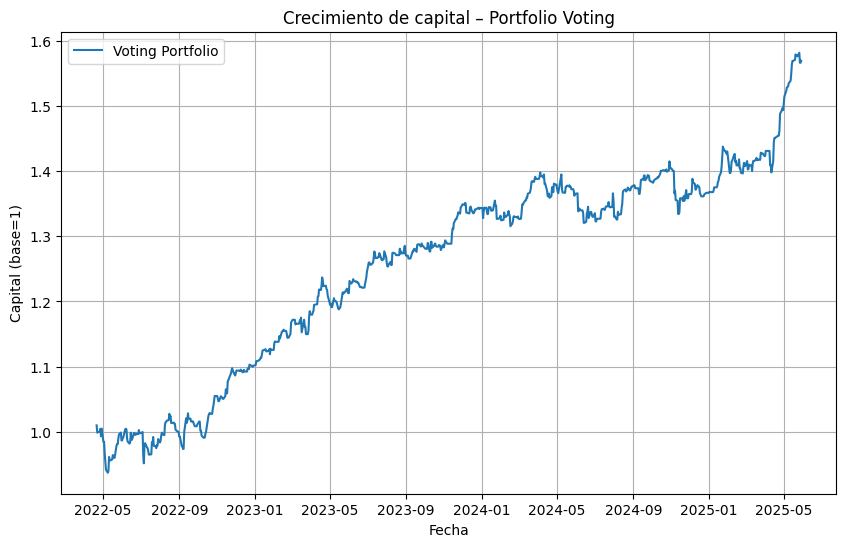

In [ ]:
# Equity curve
plt.figure(figsize=(10,6))
plt.plot(cum_port, label="Voting Portfolio")
plt.title("Crecimiento de capital – Portfolio Voting")
plt.xlabel("Fecha"); plt.ylabel("Capital (base=1)")
plt.legend(); plt.grid(True)
plt.show()

# Comparativa Benchmark

Para finalizar en este último apartado se va a:

1. **Definir el rango** de fechas de nuestro backtest a partir de la serie de capital acumulado de la cartera (`cum_port`).
2. **Descargar los precios de cierre ajustado** del índice IBEX 35 desde Yahoo Finance en el mismo intervalo.
3. **Calcular el crecimiento acumulado** de ambos (cartera e IBEX) usando retornos diarios.
4. **Alinear** ambas series al rango común de fechas.
5. **Graficar** la curva de capital comparativa.
6. **Calcular la cartera de mínima varianza de Markowitz** en el mismo intervalo
7. **Añadir al grafico** la nueva curva
8. **Calcular métricas finales** para cada una de las series.

In [40]:
# Definimos rangos
start_date = cum_port.index.min()
end_date   = cum_port.index.max() 

# Descarga IBEX
ibex_raw = yf.download(
    '^IBEX',
    start=start_date,
    end=end_date + pd.Timedelta(days=1),
    auto_adjust=True,
    progress=False
)

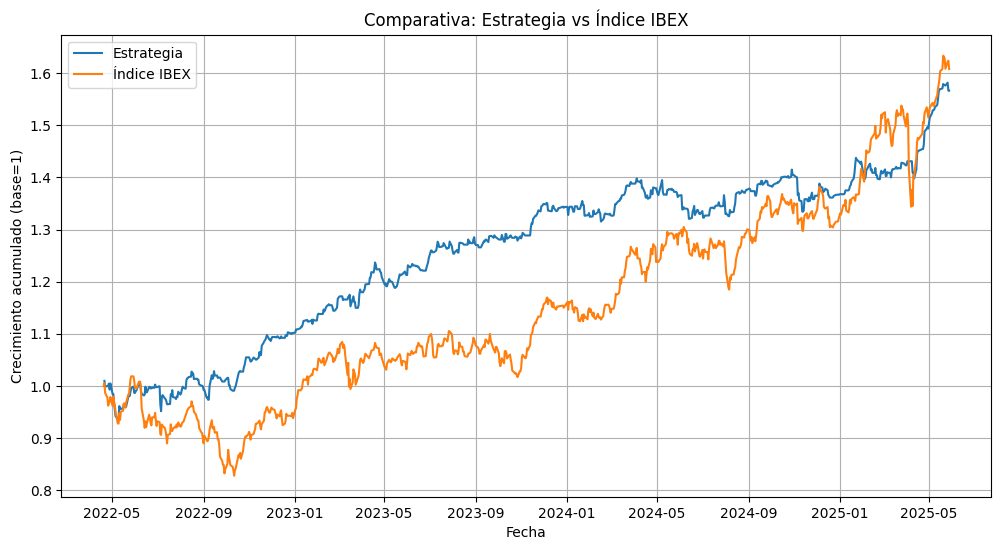

In [46]:
# Nos quedamos con la serie de cierres y forzamos que sea Serie
ibex_close = ibex_raw['Close']
if isinstance(ibex_close, pd.DataFrame):
    ibex_close = ibex_close.iloc[:, 0]

# Calculamos capital acumulado
ibex_cum = (1 + ibex_close.pct_change().fillna(0)).cumprod()

# Alineamos ambos al rango común
common_end = min(cum_port.index.max(), ibex_cum.index.max())
cum_port   = cum_port.loc[:common_end]
ibex_cum   = ibex_cum.loc[:common_end]

# Gráfica comparativa
plt.figure(figsize=(12, 6))
plt.plot(cum_port.index, cum_port, label='Estrategia')
plt.plot(ibex_cum.index, ibex_cum, label='Índice IBEX')
plt.title('Comparativa: Estrategia vs Índice IBEX')
plt.xlabel('Fecha')
plt.ylabel('Crecimiento acumulado (base=1)')
plt.legend()
plt.grid(True)
plt.show()

Calculo de la **cartera de mínima varianza de Markowitz** y la añado al gráfico anterior

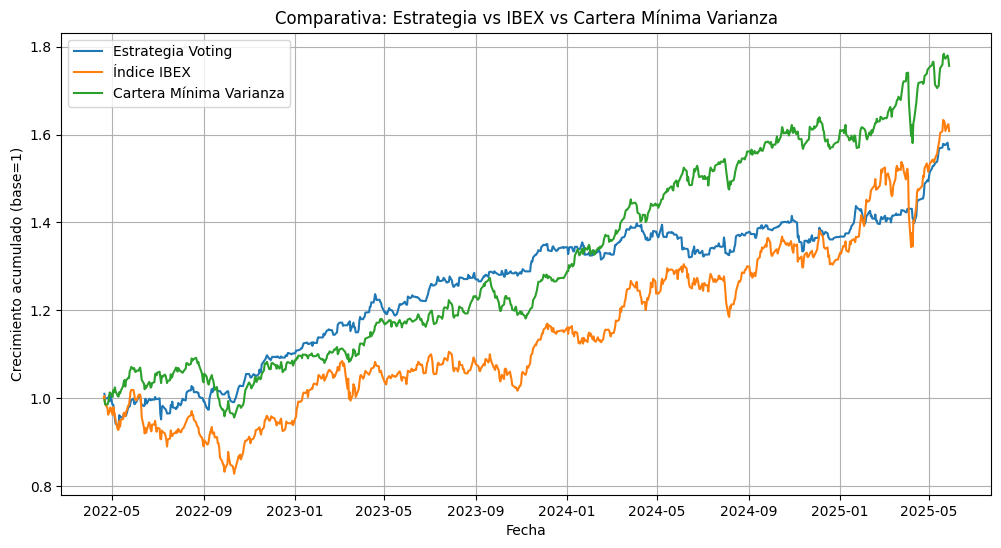

In [47]:
# Parámetros y tickers filtrados
cost_bps     = 0.0005
mv_tickers   = tickers_filtrados  # lista de los tickers filtrados de IBEX para Markowitz
start_date   = cum_port.index.min()
end_date     = cum_port.index.max()

# Precios ajustados para MV portfolio
prices_mv = pd.DataFrame({
    t: data_ibex[t]['Close']
    for t in mv_tickers
}).loc[start_date:end_date]

# Retornos diarios simples
rets_mv = prices_mv.pct_change().dropna()

# Matriz de covarianzas
cov_mv = rets_mv.cov()

# Cálculo de pesos de la cartera de mínima varianza (long‐only, sum(w)=1)
ones   = np.ones(len(mv_tickers))
inv_cov = inv(cov_mv.values)
w_mv    = inv_cov.dot(ones) / (ones.dot(inv_cov).dot(ones))
w_mv    = pd.Series(w_mv, index=mv_tickers)

# Retorno diario de la cartera MV
port_mv_ret = rets_mv.dot(w_mv)

# Aplicar coste inicial de transacción
turnover_initial          = w_mv.abs().sum()   # =1
cost_initial              = cost_bps * turnover_initial
port_mv_ret.iloc[0]      -= cost_initial

# Capital acumulado de la cartera MV
cum_mv = (1 + port_mv_ret).cumprod()

# Actualización gráfica comparativa con Estrategia y IBEX
plt.figure(figsize=(12, 6))
plt.plot(cum_port, label='Estrategia Voting')
plt.plot(ibex_cum, label='Índice IBEX')
plt.plot(cum_mv, label='Cartera Mínima Varianza')
plt.title('Comparativa: Estrategia vs IBEX vs Cartera Mínima Varianza')
plt.xlabel('Fecha')
plt.ylabel('Crecimiento acumulado (base=1)')
plt.legend()
plt.grid(True)
plt.show()


Calculo de las metricas comparativas:

In [45]:
# 1) Tasa libre de riesgo diaria
rf = 0.0

# 2) Definición de la función de métricas (incluye Calmar)
def calcular_metricas(r):
    n = len(r)
    # Retorno acumulado
    ret_acum = (1 + r).prod() - 1
    # Retorno anualizado
    ret_ann = (1 + ret_acum)**(252 / n) - 1
    # Volatilidad anualizada
    vol_ann = r.std() * np.sqrt(252)
    # Máximo drawdown
    cum = (1 + r).cumprod()
    dd = (cum / cum.cummax() - 1).min()
    # Sharpe anualizado
    sharpe = (r.mean() - rf) / r.std() * np.sqrt(252)
    # Sortino anualizado
    downside = r[r < rf]
    sortino = (r.mean() - rf) / downside.std() * np.sqrt(252) if not downside.empty else np.nan
    # Calmar ratio
    calmar = ret_ann / abs(dd) if dd != 0 else np.nan

    return pd.Series({
        'Retorno Acum.':  ret_acum,
        'Retorno Anual.': ret_ann,
        'Vol. Anual.':    vol_ann,
        'Max Drawdown':   dd,
        'Sharpe':         sharpe,
        'Sortino':        sortino,
        'Calmar':         calmar
    })

# 3) Recuperar las series de retornos diarios de cada estrategia
rent_voting    = port_ret                          # Voting (rets_df.mean(axis=1))
ibex_ret_full  = ibex_close.pct_change().fillna(0) # IBEX
rent_mv_full   = port_mv_ret                       # MV neto de costes

# 4) Alinear índices: quedarnos solo con las fechas comunes
common_idx = (
    rent_voting.index
        .intersection(ibex_ret_full.index)
        .intersection(rent_mv_full.index)
)

rent_voting = rent_voting.loc[common_idx]
rent_ibex   = ibex_ret_full.loc[common_idx]
rent_mv     = rent_mv_full.loc[common_idx]

# 5) Construir la tabla de métricas
tabla = pd.DataFrame({
    'Voting':      calcular_metricas(rent_voting),
    'IBEX':        calcular_metricas(rent_ibex),
    'MV Var. Mín.': calcular_metricas(rent_mv)
})

# 6) Mostrar por pantalla
print("\nComparativa de métricas de performance:\n")
print(tabla.to_markdown(floatfmt=".4f"))


Comparativa de métricas de performance:

|                |   Voting |    IBEX |   MV Var. Mín. |
|:---------------|---------:|--------:|---------------:|
| Retorno Acum.  |   0.5450 |  0.6079 |         0.7563 |
| Retorno Anual. |   0.1480 |  0.1627 |         0.1957 |
| Vol. Anual.    |   0.0929 |  0.1560 |         0.1093 |
| Max Drawdown   |  -0.0727 | -0.1872 |        -0.1246 |
| Sharpe         |   1.5333 |  1.0449 |         1.6904 |
| Sortino        |   1.8407 |  1.4032 |         2.2333 |
| Calmar         |   2.0376 |  0.8690 |         1.5713 |
